In [1]:
# Scientific libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from jupyterthemes import jtplot
plt.style.use('mike') 
jtplot.style(context='notebook', fscale=1, grid=False)

from glob import glob
import copy
import collections
#import warnings
#warnings.simplefilter('ignore')
from pyipn.io.plotting.projection import *
#import stan_utility

import cmdstanpy
import arviz as av
green = "#1DEBA6"
red = "#FF0059"
yellow = "#F6EF5B"

import os

import ipyvolume as ipv

from pyipn import copy_template, Universe, get_stan_model, plot_stan_fit

In [28]:
model = get_stan_model("rff_ipn.stan")

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/jburgess/sw/pyipn/pyipn/stan_models/rff_ipn


In [54]:
uni = Universe.from_yaml('template_3.yaml')
uni.explode_grb(tstart=-50,tstop=100)
print(uni._T0)
uni.plot_all_annuli(cmap='rainbow',lw=1, threeD=True);

[0.34328823 0.        ]


<IPython.core.display.Javascript object>


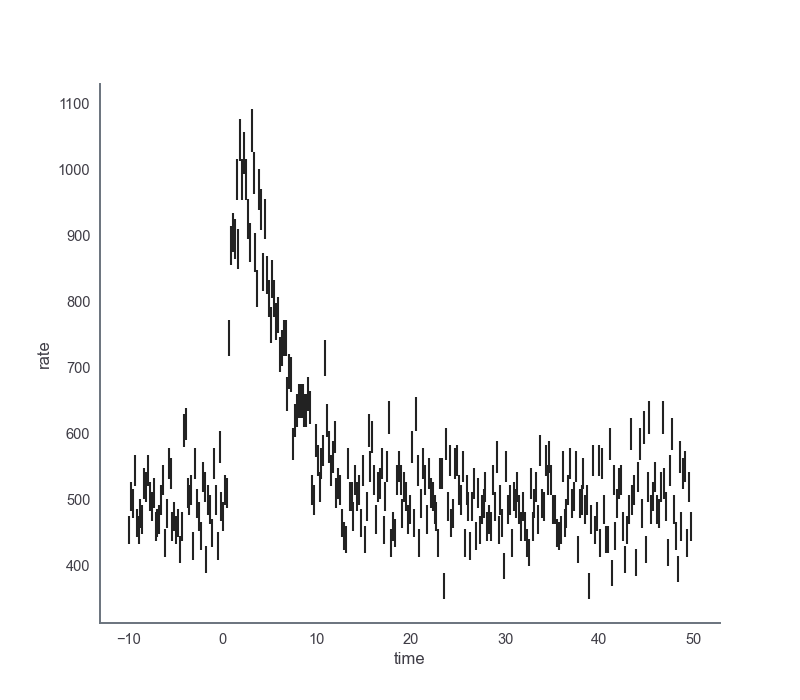

<IPython.core.display.Javascript object>


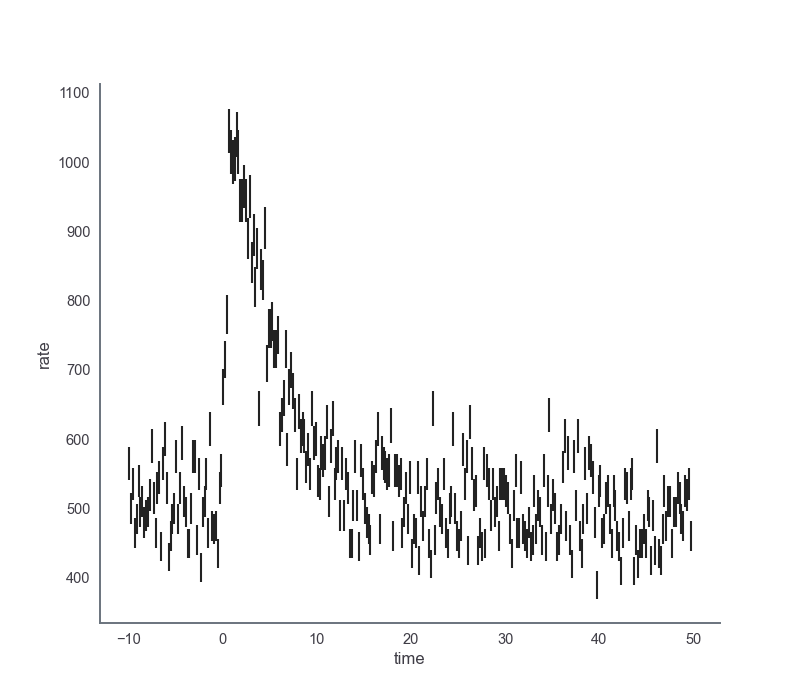

In [55]:
for det, lc in uni.light_curves.items():
    
    lc.display(-10,50,.2)
    

In [69]:
np.logspace(-1,1, 10)

array([ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
        1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ])

In [56]:
data = uni.to_stan_data(-10,40,dt=.2, k=50 )


In [61]:
warmup = 500
samp = 500


# fit = model.sampling(warmup=500,iter=750,data=data, chains=4, seed=1234,
#                      control = dict(max_treedepth=13, adapt_delta=.9))
os.environ["STAN_NUM_THREADS"] = "46"


data["bw"] = 1.2

fit = model.sample(
    data=data,
    cores=96,
    iter_warmup=warmup,
    iter_sampling=samp,
    chains=2,
    max_treedepth=10,
    show_progress="notebook",
#    metric="diag_e",
    seed=16574)


ar = av.from_cmdstanpy(fit)

<IPython.core.display.Javascript object>


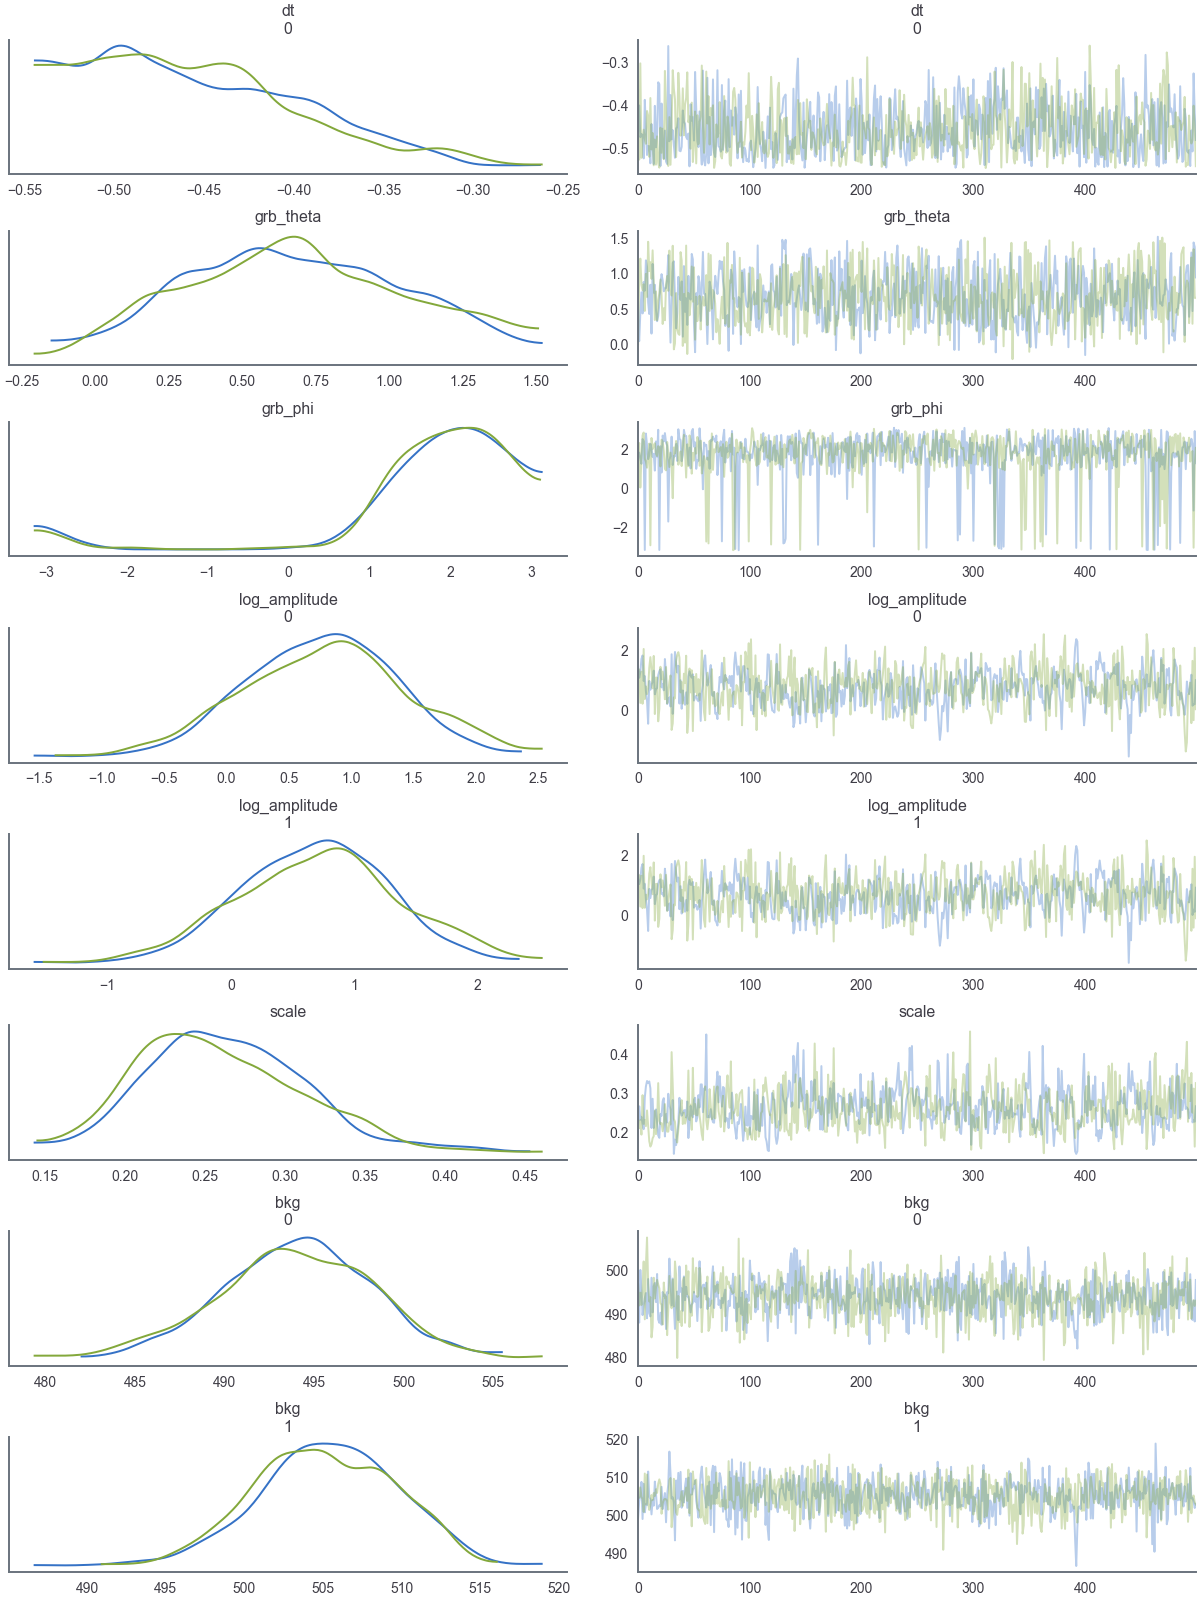

In [62]:

  av.plot_trace(ar, var_names=[#'beta1','beta2',
               'dt',
              'grb_theta',
              'grb_phi',
              'log_amplitude',
#              'bw'
      'scale',
      "bkg"

             
             ]);

In [63]:
def RFF(time, omega1, omega2, beta1, beta2, bw, scale):
    
    
    features1 = bw * np.outer(time, omega1)
    features2 = bw * np.outer(time, omega2)
    
    fhat = np.exp( scale * (np.dot( np.cos(features1) + np.cos(features2), beta1) + np.dot(np.sin(features1) + np.sin(features2), beta2)))
    
    
    return fhat
    
    
# def RFF(time, omega1, omega2, beta1, beta2, bw, scale):
    
    
#     features1 = 1 * np.outer(time, omega1)
#     features2 = 1 * np.outer(time, omega2)
    
#     fhat = np.exp(  (np.dot( np.cos(features1) + np.cos(features2), beta1) + np.dot(np.sin(features1) + np.sin(features2), beta2)))
    
    
#     return fhat
    
    
    
    
    

In [71]:
model.sample?

In [64]:
beta1 = np.array(ar.posterior.beta1).reshape(-1, ar.posterior.beta1.shape[-1])
beta2 = np.array(ar.posterior.beta2).reshape(-1, ar.posterior.beta2.shape[-1])
omega = np.array(ar.posterior.omega).reshape(-1, 2 ,ar.posterior.omega.shape[-1])

# omega1 = np.array(ar.posterior.omega1).reshape(-1, ar.posterior.omega1.shape[-1])
# omega2 = np.array(ar.posterior.omega2).reshape(-1, ar.posterior.omega2.shape[-1])



amplitude = np.array(ar.posterior.amplitude).reshape(-1,ar.posterior.amplitude.shape[-1])

dt = np.array(ar.posterior.dt).reshape(-1,ar.posterior.dt.shape[-1])


scale = np.array(ar.posterior.scale).flatten()

bkg = np.array(ar.posterior.bkg).reshape(-1, ar.posterior.bkg.shape[-1])

#bw = np.array(ar.posterior.bw).flatten()



<IPython.core.display.Javascript object>


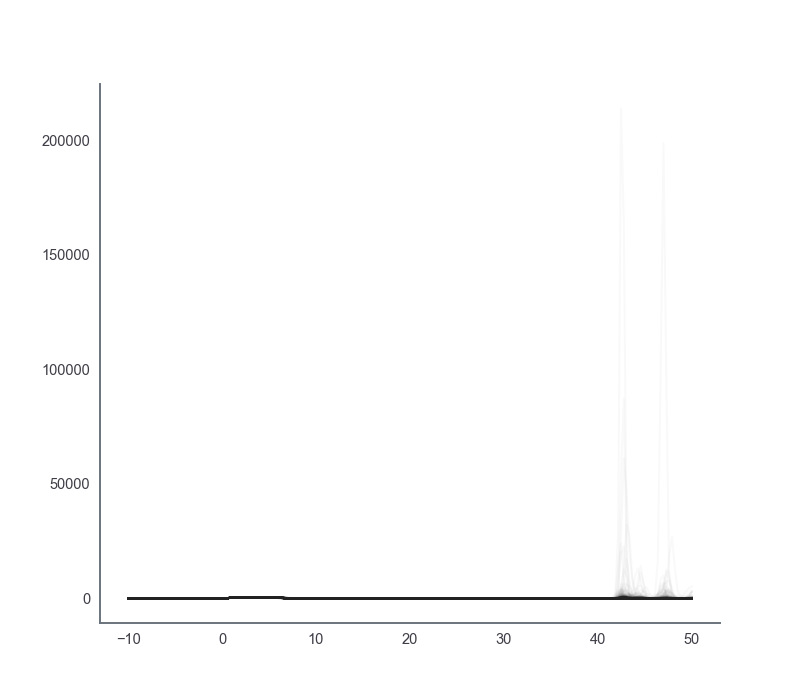

In [65]:
time = np.linspace(-10, 50, 200)

bw = 1.2

fig, ax = plt.subplots()

for i in range(beta1.shape[0]):
    
    lc = RFF(time, omega[0,0,:], omega[0,1,:], beta1[i, :], beta2[i,:], bw, scale[i])
   # lc = RFF(time, omega1[i,:], omega2[i,:], beta1[i, :], beta2[i,:], bw[i], scale[i])


    ax.plot(time, amplitude[i, 0]*lc, color='k', alpha=.025)
    
    
# for i in range(beta1.shape[0]):
    
#     lc = RFF(time, omega[0,0,:], omega[0,1,:], beta1[i, :], beta2[i,:], bw[i], scale[i])
    
#     ax.plot(time - dt[i,0] , amplitude[i, 0]*lc, color='r', alpha=.005)
    

# for i in range(beta1.shape[0]):
    
#     lc = RFF(time, omega[0,0,:], omega[0,1,:], beta1[i, :], beta2[i,:], 1, scale[i])
    
#     ax.plot(time - dt[i,1] , amplitude[i, 0]*lc, color='blue', alpha=.005)    

    
# for i in range(beta1.shape[0]):
    
#     lc = RFF(time, omega[0,0,:], omega[0,1,:], beta1[i, :], beta2[i,:], 1, scale[i])
    
#     ax.plot(time - dt[i,2] , amplitude[i, 0]*lc, color='green', alpha=.005)  
# #ax.set_ylim(0, 100)



In [66]:
uni.plot_all_annuli(cmap='Set1',lw=3, threeD=True);
raw_xyz = np.array(ar.posterior.grb_xyz).reshape(-1, ar.posterior.grb_xyz.shape[-1])
rad = uni.grb_radius

scatter = rad + np.random.normal(0, rad * 0.05, size=len(raw_xyz))



xyz = rad * raw_xyz


ipv.scatter(xyz[:,0],xyz[:,1],xyz[:,2],marker="sphere", color="blue", size=.3)



Scatter(color=array('blue', dtype='<U4'), color_selected=array('white', dtype='<U5'), geo='sphere', line_mater…

<IPython.core.display.Javascript object>


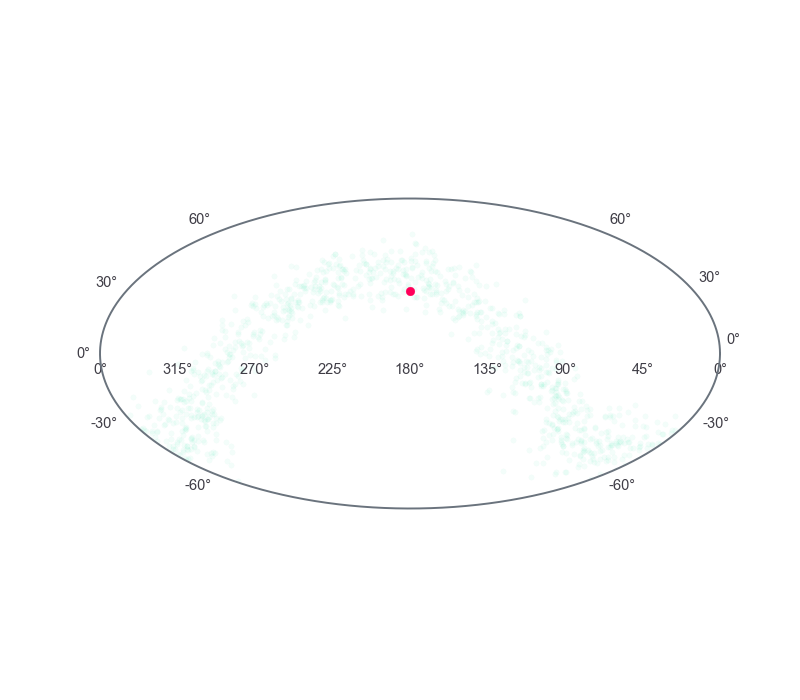

In [48]:
# fig = uni.plot_all_annuli(cmap='magma',lw=3);

# ax = fig.get_axes()[0]

grb_theta = np.array(ar.posterior.grb_theta).reshape(-1, ar.posterior.grb_theta.shape[-1])
grb_phi = np.array(ar.posterior.grb_phi).reshape(-1, ar.posterior.grb_phi.shape[-1])

fig, ax = plt.subplots(subplot_kw=dict(projection='astro degrees mollweide',
                                      # center=SkyCoord(135,-22,unit='deg')
                                      ))

theta = np.rad2deg(grb_theta)
phi = np.rad2deg(grb_phi)



idx = phi <= 0

phi[idx] +=360


ax.scatter(phi, theta, c=green, alpha=.05, transform=ax.get_transform("icrs"), s=15)
ax.scatter(np.array([180.]),np.array([30.]),c=red, s=40,transform=ax.get_transform("icrs"))

#uni.plot_all_annuli(cmap='magma',lw=3);

In [35]:

from pyipn.geometry import Location
from pyipn.io.plotting.spherical_circle import SphericalCircle
def compute_annulus_from_time_delay(time_delay, detector1, detector2, ax =None ,color=green,**kwargs):
    
    dxyz = (  detector2.location.get_cartesian_coord().xyz - detector1.location.get_cartesian_coord().xyz)
            
    dcart = Location(
    SkyCoord(
        x=dxyz[0],
        y=dxyz[1],
        z=dxyz[2],
        representation_type="cartesian",
        unit="km",
     #   frame='icrs'
    )
        )
    
    
    norm_d = dcart.get_norm_vec(u.km)
    
    distance = np.linalg.norm(dxyz) * u.km
    
    theta = np.arccos(
            np.around(((-const.c * time_delay*u.s ).to('km')/ distance).value, 15)
        )
    
    
    ra = dcart.coord.represent_as(UnitSphericalRepresentation).lon
    dec = dcart.coord.represent_as(UnitSphericalRepresentation).lat
    
    
    if ax is None:
        fig, ax = plt.subplots(subplot_kw=dict(projection='astro degrees mollweide'))
    
    circle = SphericalCircle(
            np.array([ra.value, dec.value]) * ra.unit,
            theta*u.rad,
            vertex_unit=u.deg,
            resolution=5000,
            edgecolor=color,
            facecolor="none",
            transform=ax.get_transform("icrs"),
        **kwargs
       
  
        )
    
    
   
    
    ax.add_patch(circle)
    


<IPython.core.display.Javascript object>


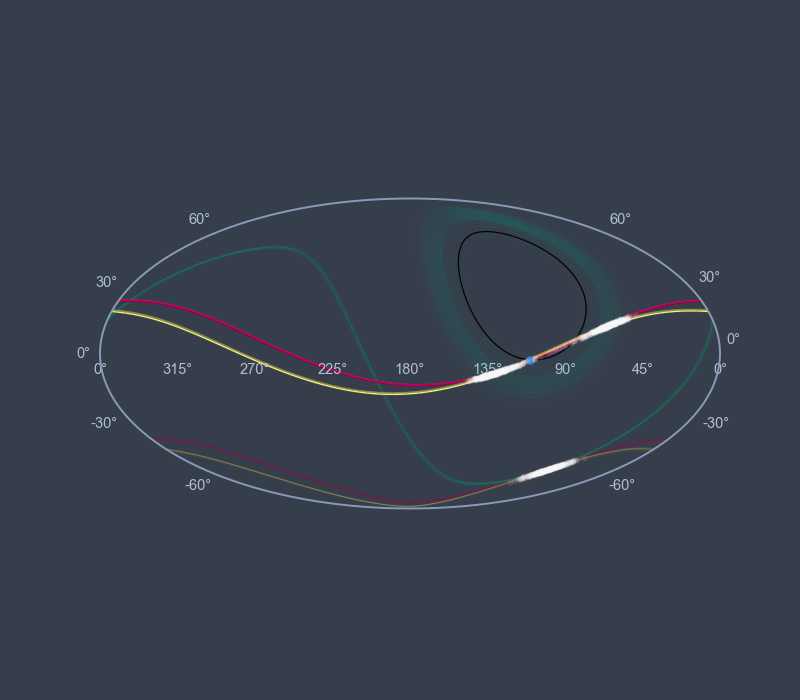

In [38]:
 dt = fit.extract('dt_1_2')['dt_1_2']
# fig, ax = plt.subplots(subplot_kw=dict(projection='astro globe',
#                                        center=SkyCoord(135,-22,unit='deg', frame='icrs') ))

fig = uni.plot_all_annuli(cmap='magma',lw=.9);

ax = fig.get_axes()[0]
for d in dt[::10]:

    compute_annulus_from_time_delay(d, detector1=uni.detectors['det1'],
                                    detector2=uni.detectors['det2'], ax = ax,alpha=.05 )
    

dt = fit.extract('dt_1_3')['dt_1_3']
#fig, ax = plt.subplots(subplot_kw=dict(projection='astro degrees mollweide'))
for d in dt[::10]:

    compute_annulus_from_time_delay(d, detector1=uni.detectors['det1'],
                                    detector2=uni.detectors['det3'], ax = ax,color=red,alpha=.05 )
    
    
    
    
dt = fit.extract('dt_2_3')['dt_2_3']
#fig, ax = plt.subplots(subplot_kw=dict(projection='astro degrees mollweide'))
for d in dt[::10]:

    compute_annulus_from_time_delay(d, detector1=uni.detectors['det2'],
                                    detector2=uni.detectors['det3'], ax = ax,color=yellow,alpha=.05 )
    
    
theta = np.rad2deg(fit.extract('grb_theta')['grb_theta'])
phi = np.rad2deg(fit.extract('grb_phi')['grb_phi'])



idx = phi <= 0

phi[idx] +=360


ax.scatter(phi, theta, c='w', alpha=.1, transform=ax.get_transform("icrs"), s=15,zorder=200)
    
ax.scatter(np.array([110.]),np.array([-3.]),c='b', s=40,transform=ax.get_transform("icrs"), zorder=100)
    